In [59]:
import numpy as np
import matplotlib.pyplot as plt

In [60]:
options = ["left", "right","up","down"]
options_symb = ["⭠","⭢","⭡","⭣"]

In [61]:
dij_from_options = [(-1,0), (1,0), (-1,0), (1,0)]

In [62]:
def show_space(space:np.array, show_val=False):
    fig, ax = plt.subplots()
    im = ax.imshow(space)
    x,y = space.shape
    if show_val:
        for i in range(x):
            for j in range(y):
                ax.text(i,j,f"{space[j][i]:.1f}", ha= "center",va="center", color="w")
    fig.tight_layout()
    plt.show()

In [63]:
def get_ij(i,j,dir_:str,space:np.array)->tuple[int,int]:
    si, sj = space.shape
    di = 0
    dj = 0
    if dir_ == "up":
        di = -1
    if dir_ == "down":
        di = +1
    if dir_ == "left":
        dj = -1
    if dir_ == "right":
        dj = 1
    if i+di < 0 or i+di>si-1:
        di = 0
    if j+dj < 0 or j+dj > sj-1:
        dj = 0
    return i+di,j+dj

def get_vij(i,j,dir_:str,V_:np.array)->float:
    i,j = get_ij(i,j,dir_,V_)
    return V_[i][j]

def get_rij(i,j,dir_:str,R:np.array)->float:
    i,j = get_ij(i,j,dir_,R)
    return R[i][j]

def calculate_vij(i:int,j:int,V_:np.array, R_:np.array, gamma = 0.9, p = 1/4):
    if (i == 0 and j == 0):
        return 0
    vij = 0
    for opt in options:
        vij += p*(get_rij(i,j,opt,R_)+ gamma * get_vij(i,j,opt,V_))
    return vij

def calculate_vp(V:np.array, rewards:np.array,gamma = 0.9, p = 1/4):
    si, sj = V.shape
    v_p = np.zeros_like(V)
    for i in range(si):
        for j in range(sj):
            v_p[i][j] = calculate_vij(i,j,V,rewards,gamma,p)
    return v_p

In [64]:
def get_direction(i,j,V:np.array, tolerance = 1e-4):
    si, sj = V.shape
    if (i == 0 and j == 0):
        return " "
    a_val = [get_vij(i,j,op,V) for op in options]
    if np.all(np.isclose(a_val, a_val[0], atol=tolerance)):
        return "✥"
    
    if (a_val[0] == a_val[1] and a_val[0] == np.max(a_val)):
        return "↔"
    if (a_val[0] == a_val[3] and a_val[1] == a_val[2] and a_val[0] == np.max(a_val)) and a_val[1] == np.max(a_val):
        return "⤡"
    if (a_val[0] == a_val[2] and a_val[1] == a_val[3] and a_val[0] == np.max(a_val)) and a_val[1] == np.max(a_val):
        return "⤢"
    
    if (np.isclose(a_val[0], a_val[2], atol=tolerance) and np.isclose(a_val[0], np.max(a_val), atol=tolerance)):
        return "⭩"
    if (np.isclose(a_val[0], a_val[3], atol=tolerance) and np.isclose(a_val[0], np.max(a_val), atol=tolerance)):
        return "⭦"
    
    if (np.isclose(a_val[1], a_val[2], atol=tolerance) and np.isclose(a_val[1], np.max(a_val), atol=tolerance)):
        return "⭨"
    if (np.isclose(a_val[1], a_val[3], atol=tolerance) and np.isclose(a_val[1], np.max(a_val), atol=tolerance)):
        return "⭧"
    
    return options_symb[np.argmax(a_val)]
    
def show_directions(V:np.array, tolerance = 1e-8):
    x, y = V.shape
    for i in range(x):
        row = []
        for j in range(y):    
            row.append(get_direction(i,j,V, tolerance=tolerance))
        print(" ".join(row))

In [65]:
def iterative_policy_calculation(V:np.array,R:np.array, gamma=0.9, theta = 1e-5, limit = 1000):
    it = 0
    while True:
        delta = 0
        x,y = V.shape
        for i in range(x):
            for j in range(y):
                if i == 0 and j == 0:
                    continue
                v_p = calculate_vij(i,j,V,R, gamma)
                delta = max(delta,np.abs(v_p-V[i,j]))
                V[i,j] = v_p
                if delta < theta or np.isclose(delta,theta):
                    return V
        if delta < theta:
            break
        it += 1
        if it%10000 == 0:    
            print(f"Ended by iterations delta {delta} i:{it}")
            return V
    return V

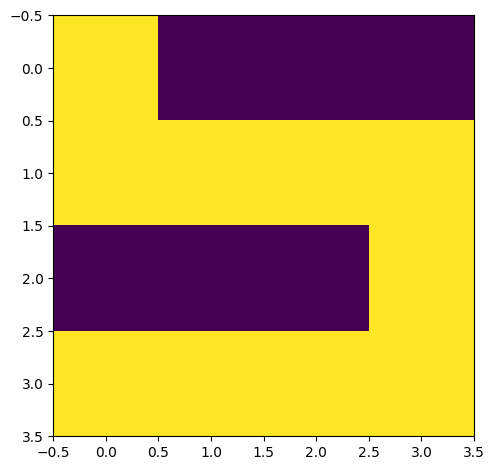

In [66]:
R = np.array([[-1,-10,-10,-10],[-1,-1,-1,-1],[-10,-10,-10,-1],[-1,-1,-1,-1]])
show_space(R)

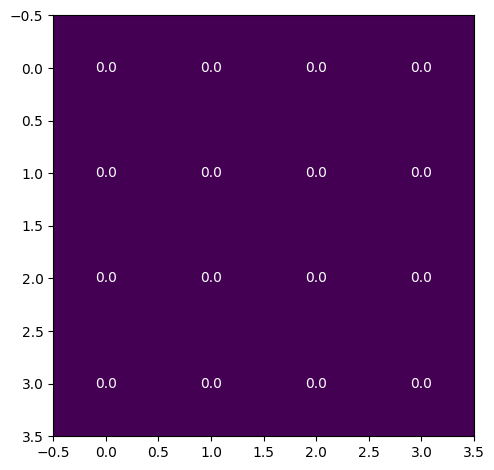

In [67]:
V = np.zeros((4,4))
show_space(V,True)

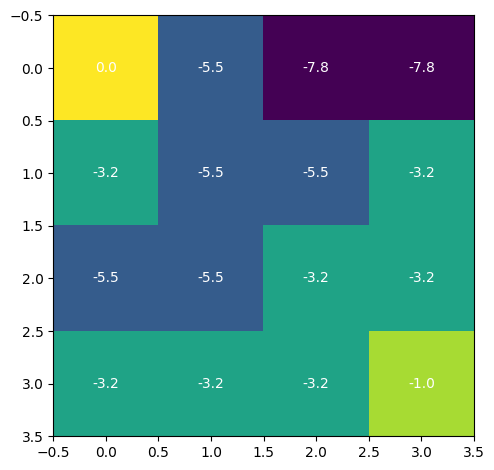

In [68]:
V_p = calculate_vp(V, R, p = 1/4)
show_space(V_p,True)

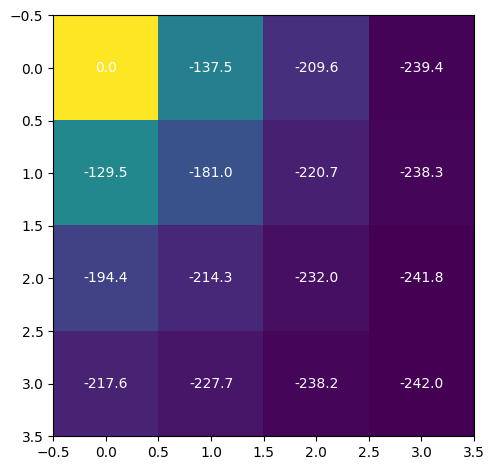

In [69]:
for i in range(1000):
    V_p = calculate_vp(V_p,R, 1)
show_space(V_p,True)

In [70]:
Vp = iterative_policy_calculation(V,R, theta = 1e-8, limit=1000, gamma=1)
print(Vp)
show_directions(Vp)

[[   0.         -137.51785654 -209.55357048 -239.42857034]
 [-129.48214224 -180.99999916 -220.71428469 -238.3035703 ]
 [-194.44642763 -214.28571326 -231.99999888 -241.76785596]
 [-217.57142748 -227.69642745 -238.23214167 -241.99999878]]
  ⭠ ⭠ ⭠
⭡ ⭠ ⭠ ⭠
⭡ ⭡ ⭠ ⭠
⭡ ⭡ ⭠ ⭠


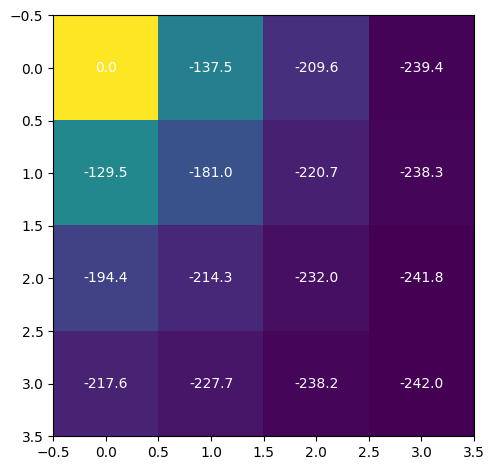

 ⭠ ⭠ ⭠
⭡ ⭠ ⭠ ⭠
⭡ ⭡ ⭡ ⭡
⭡ ⭠ ⭠ ⭠


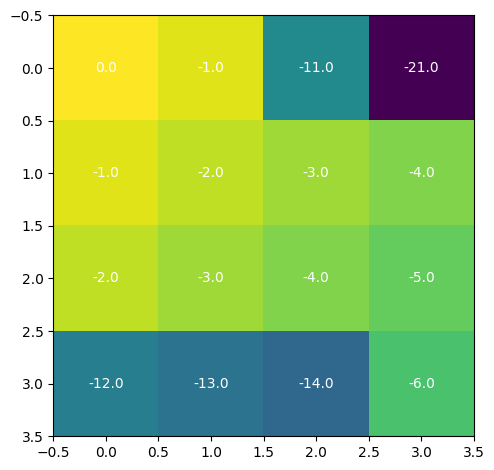

 ⭠ ⭣ ⭣
⭡ ⭠ ⭠ ⭠
⭡ ⭡ ⭡ ⭡
⭡ ⭠ ⭢ ⭡


In [71]:
def policy_movement(i,j,V:np.array,R:np.array,gamma=1, p = 1/4):
    if (i == 0 and j == 0):
        return -1
    values = [get_vij(i,j,op,V) for op in options]
    rewards = [get_rij(i,j,op,R) for op in options]
    values = [p*(r+gamma*v) for r,v in zip(rewards,values)]
    return np.argmax(values)

def show_policy_directions(V:np.array, R:np.array,gamma=1, p = 1/4):
    x, y = V.shape
    for i in range(x):
        row = []
        for j in range(y):
            if (i == 0 and j == 0):
                row.append("")
                continue
            row.append(options_symb[policy_movement(i,j,V,R, gamma,p)])
        print(" ".join(row))

def get_policy_matrix(V:np.array,R:np.array, gamma = 1, p = 1/4):
    x, y = V.shape
    pi = V
    for i in range(x):
        for j in range(y):
            if i == 0 and j == 0:
                pi[i,j] = 0
            else:
                op = options[policy_movement(i,j,pi,R, gamma,p)]
                value = get_vij(i,j,op,pi)
                reward = get_rij(i,j,op,R)
                pi[i,j] = reward + value
    return pi

show_space(Vp, True)
show_policy_directions(Vp,R)
Vpi = get_policy_matrix(Vp.copy(),R)
show_space(Vpi, True)
show_policy_directions(Vpi,R)

In [72]:
def movement_from_policy_calculation(i,j,V:np.array, R:np.array, gamma= 1, p = 1/4):
    if (i == 0 and j == 0):
        return -1
    ijs = [get_ij(i,j,op, V) for op in options]
    values = [calculate_vij(i_,j_,V, R, gamma, p) for i_,j_ in ijs]
    return np.argmax(values)

  
def policy_calculation(i,j,V:np.array, R:np.array, gamma= 1, p = 1/4):
    if (i == 0 and j == 0):
        return -1
    ijs = [get_ij(i,j,op, V) for op in options]
    vijs = [get_vij(i,j,op, V) for op in options] 
    rijs = [get_rij(i,j,op, R) for op in options] 
    ps = [v/sum(vijs) for v in vijs]
    
    values = [calculate_vij(i_,j_,V, R, gamma, p) for i_,j_ in ijs]
    return np.max(values)

def show_movement_from_policy_calculation(i,j,V:np.array, R:np.array, gamma= 1, p = 1/4):
    return options_symb[movement_from_policy_calculation(i,j,V,R , gamma, p)]

def show_movements_from_pi(V:np.array,R:np.array, gamma = 1, p = 1/4 ):
    x, y = V.shape
    for i in range(x):
        row = []
        for j in range(y):
            if i == 0 and j == 0:
                row.append(" ")
            else:
                row.append(show_movement_from_policy_calculation(i,j,V,R,gamma,p))
        print(" ".join(row))

In [73]:
show_policy_directions(Vp,R)
print("=="*15)
show_movements_from_pi(Vp, R)

 ⭠ ⭠ ⭠
⭡ ⭠ ⭠ ⭠
⭡ ⭡ ⭡ ⭡
⭡ ⭠ ⭠ ⭠
  ⭠ ⭠ ⭠
⭡ ⭠ ⭠ ⭠
⭡ ⭡ ⭠ ⭠
⭡ ⭡ ⭠ ⭠


[[  0.  -1. -11. -21.]
 [ -1.  -2.  -3.  -4.]
 [ -2.  -3.  -4.  -5.]
 [-12. -13. -14.  -6.]]


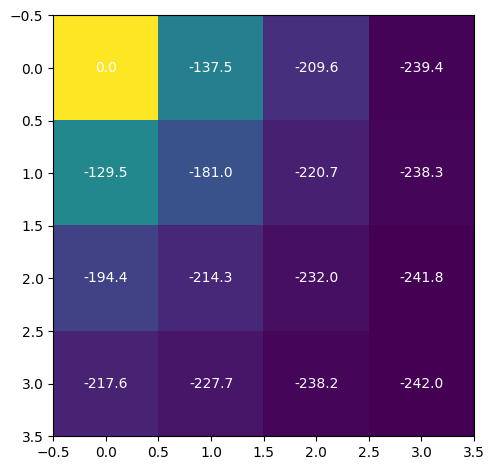

In [74]:
Vp = get_policy_matrix(Vp,R)
print(Vp)
Vp = iterative_policy_calculation(Vp,R, theta = 1e-8, limit=1000, gamma=1)
show_space(Vp,True)

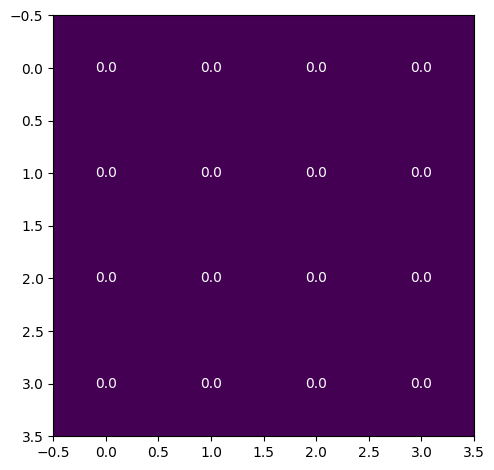

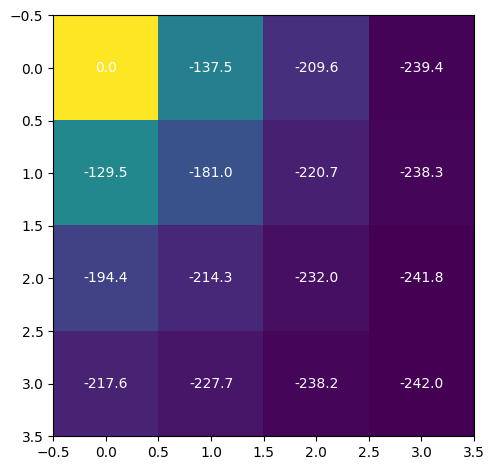

 ⭠ ⭠ ⭠
⭡ ⭠ ⭠ ⭠
⭡ ⭡ ⭡ ⭡
⭡ ⭠ ⭠ ⭠
------------------------------


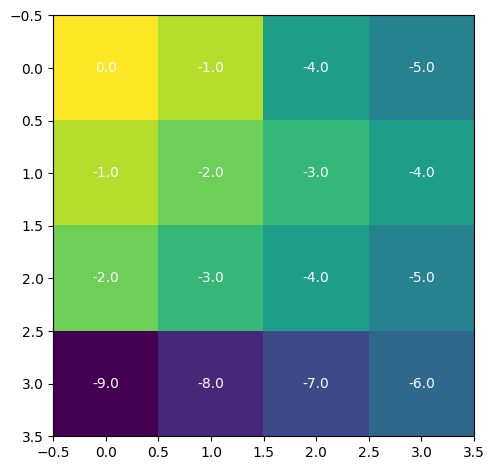

 ⭠ ⭣ ⭣
⭡ ⭠ ⭠ ⭠
⭡ ⭡ ⭡ ⭡
⭢ ⭢ ⭢ ⭡


In [58]:
def policy_improvement(V:np.array, R:np.array, gamma = 1, p = 1/4):
    x, y = V.shape
    stable = True
    V_old = V.copy()
    V = get_policy_matrix(V,R, gamma, p)
    stable = np.all(V==V_old)
    if not stable:
        return policy_improvement(V, R, gamma, p)
    return V

V = np.zeros((4,4))
show_space(V, True)

Vp = iterative_policy_calculation(V,R,1,1e-6)
show_space(Vp, True)
show_policy_directions(Vp,R)
Vpi = policy_improvement(Vp,R)

print("--"*15)
show_space(Vpi, True)
show_policy_directions(Vpi,R)